In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'darkgrid')
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

# Tier-1 Model Input Dataset

In [61]:
train_split=pd.read_csv('./Train.csv')

test_split=pd.read_csv('./Test.csv')


X_train_ = train_split.drop(['site_no','Mean Discharge','RatingCurve_Coeff','RatingCurve_Expo'],axis=1)

X_val_ = test_split.drop(['site_no','Mean Discharge','RatingCurve_Coeff','RatingCurve_Expo'],axis=1)

y_train_ = train_split[['RatingCurve_Coeff']]
y_val_ = test_split[['RatingCurve_Coeff']]

print(X_val_)

           Qobs     W_mean    D_mean  (W/D)mean  Stage_mean       Qbank   
0      6.603478  22.440900  0.944880      23.75    0.466344   35.180935  \
1     12.069244  25.257252  0.678180      37.24    0.646176   44.457378   
2     23.899380  40.538400  0.655320      61.86    0.960120   55.143714   
3     42.145424  71.738033  1.478280      48.53    1.542288  136.413272   
4     10.533850  25.798272  1.456944      17.71    1.331976   17.505220   
..          ...        ...       ...        ...         ...         ...   
458  106.382399  52.236624  2.795016      18.69    2.243328  261.088522   
459    9.988978  36.447984  0.650443      56.04    0.752856  359.798002   
460   87.895860  41.553994  4.670146       8.90    4.437888  126.475802   
461   13.105242  22.806355  0.582168      39.17    3.054096  225.344564   
462    9.323873  17.761001  1.198474      14.82    1.005840   52.644671   

        W_bank    D_bank  (W/D)bank  Stage_bank  ...        AI    D50_mm   
0    22.959365  1.58800

# Tier-2 Model Input Dataset

In [79]:

train_split=pd.read_csv('./Train_secondtier.csv')

test_split=pd.read_csv('./Test_secondtier.csv')


X_train_ = train_split.drop(['site_no','Rating Curve Coeff','RatingCurve Exponent'], axis=1)

X_val_ = test_split.drop(['site_no','Rating Curve Coeff','RatingCurve Exponent'],axis=1)

y_train_ = train_split[['Rating Curve Coeff']]

y_val_ = test_split[['Rating Curve Coeff']]



In [80]:

from sklearn.ensemble import RandomForestRegressor

param_grid = {'max_depth': range(8, 15, 2),
              'max_features': ['auto', 'sqrt'],
              'min_samples_leaf': range(1, 8, 20),
              'min_samples_split': [5, 6, 7, 8],
              'n_estimators': [10, 20, 150],
              'bootstrap': [True, False]
              }
rf = RandomForestRegressor(n_jobs=-1, random_state=42)
rf_grid = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1, verbose=True)


In [81]:
rf_grid.fit(X_train_.to_numpy(), y_train_.to_numpy().ravel(), groups=train_split['site_no'])

Fitting 5 folds for each of 192 candidates, totalling 960 fits


/Users/abaruah/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/abaruah/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/abaruah/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also th

GridSearchCV(estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': range(8, 15, 2),
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': range(1, 8, 20),
                         'min_samples_split': [5, 6, 7, 8],
                         'n_estimators': [10, 20, 150]},
             verbose=True)

In [82]:
print(rf_grid.best_params_)
print(rf_grid.best_score_)

{'bootstrap': False, 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}
0.5104005392105195


In [83]:
import pickle
with open('./rf_best_model', "wb") as fp:
    pickle.dump(rf_grid.best_estimator_, fp)

In [84]:
with open('./rf_best_model', "rb") as fp:
    rf_grid = pickle.load(fp)

In [85]:
rf_pred = rf_grid.predict(X_val_)

/Users/abaruah/anaconda3/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


R²: 0.5192748301374694


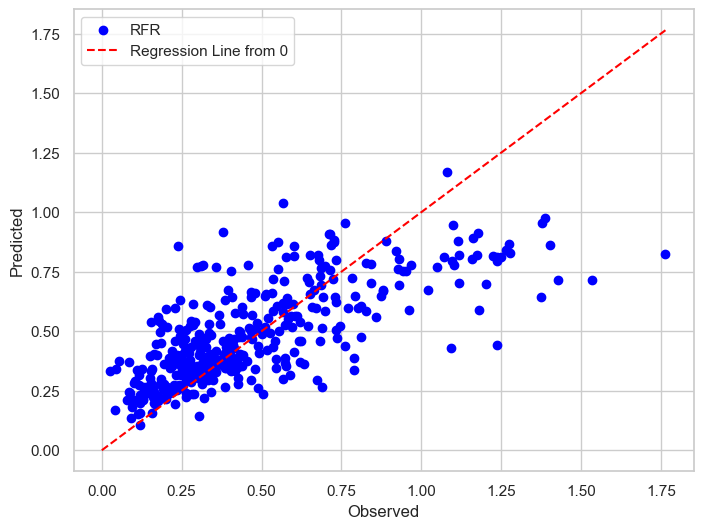

In [97]:
y_test = np.ravel(y_val_)
y_pred = np.ravel(rf_pred)


polyfit_coeffs = np.polyfit(y_test, y_pred, 1)  # Ensure inputs are 1D
trendline = np.poly1d(polyfit_coeffs)
r2 = r2_score(y_test, y_pred)
print(f'R\u00b2: {r2}')

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', marker='o', label='RFR')
max_y = max(max(y_pred), max(y_test))
plt.plot([0, max_y], [0, max_y], color='red', linestyle='--', label='Regression Line from 0')

# Plot the polyfit trendline

# Adding labels and title
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.legend()

plt.show()
